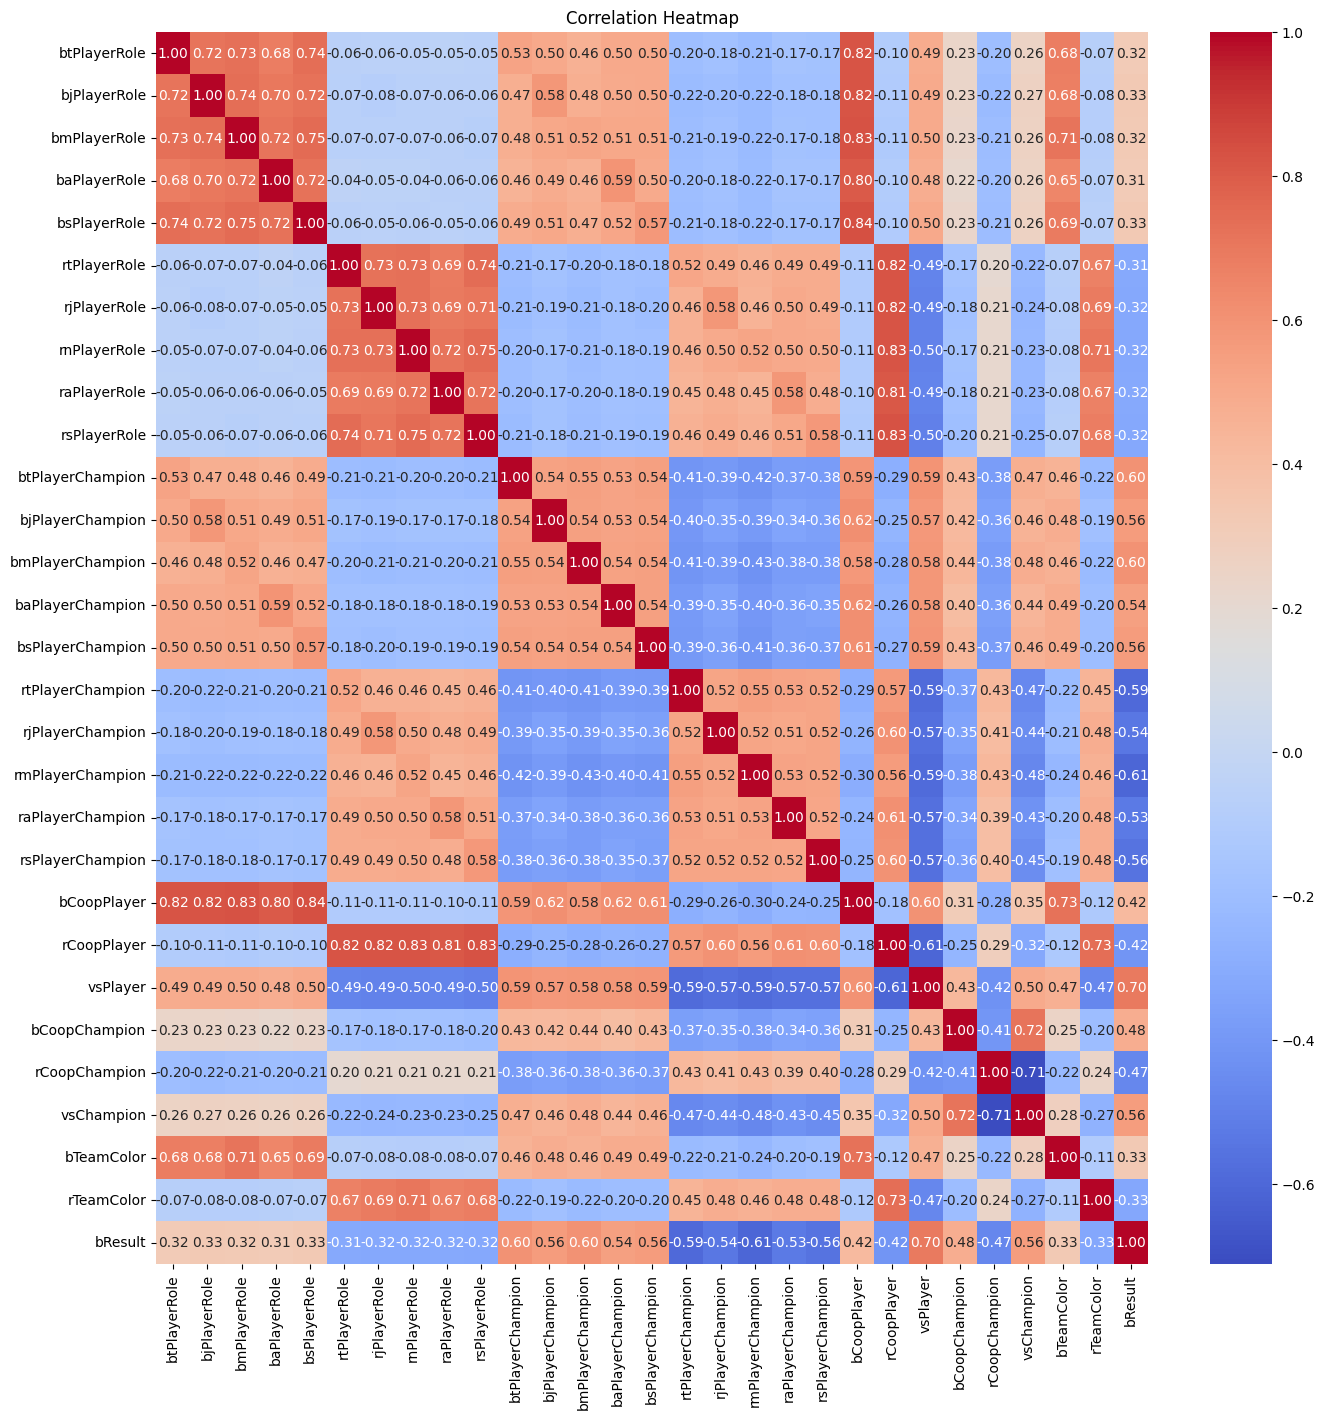

Features with high correlation to the target:
 bResult             1.000000
vsPlayer            0.698907
rmPlayerChampion    0.608310
btPlayerChampion    0.603913
bmPlayerChampion    0.602946
rtPlayerChampion    0.592449
bsPlayerChampion    0.564752
bjPlayerChampion    0.560847
vsChampion          0.556289
rsPlayerChampion    0.555020
rjPlayerChampion    0.541690
baPlayerChampion    0.538911
raPlayerChampion    0.530289
bCoopChampion       0.484737
rCoopChampion       0.473726
bCoopPlayer         0.417016
rCoopPlayer         0.416028
bTeamColor          0.327004
rTeamColor          0.325964
bsPlayerRole        0.325826
bjPlayerRole        0.325583
rsPlayerRole        0.322525
bmPlayerRole        0.319954
rnPlayerRole        0.318536
rjPlayerRole        0.318509
btPlayerRole        0.316537
raPlayerRole        0.315693
baPlayerRole        0.314709
rtPlayerRole        0.311653
Name: bResult, dtype: float64


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgbStack
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import load_data

modelInstance = xgbStack.xgbStack()
match_df_train = modelInstance.import_data(True, bGenerateOutputFile=False)
match_df_test = modelInstance.import_data(False, bGenerateOutputFile=False)

x_train, y_train = modelInstance.extract_labels(match_df_train)
x_test, y_test = modelInstance.extract_labels(match_df_test)    

x_combined = pd.concat([x_train, x_test])
y_combined = pd.concat([y_train, y_test])
df_combined = x_combined.copy()
df_combined['bResult'] = y_combined

correlation_matrix = df_combined.corr()
plt.figure(figsize=(16, 16)) #Adjust width and height of image.
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size" : 10})
plt.title("Correlation Heatmap")
plt.show()

# Check for high correlations with target
high_corr_features = correlation_matrix['bResult'].abs().sort_values(ascending=False)
print("Features with high correlation to the target:\n", high_corr_features)
